In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.ensemble import RandomForestClassifier



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
pwd = os.getcwd()
file_loc2 = os.path.join(pwd,'gdrive/MyDrive/IS733 Project/insurance_data_clean4viz_12222022.csv')

### Accessing our Cleaned Dataset:

In [3]:
import pandas as pd
df = pd.read_csv(file_loc2)

In [4]:
df.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Carrier Type,Claim Injury Type,Closed Count,Current Claim Status,District Name,Gender,Hearing Count,Highest Process,Occupational Disease,Claim Assembly Time Lag
0,44,N,Y,546.69,4A. SELF PRIVATE,3. MED ONLY,1,MOTION SET,NYC,M,0,2. ADMINISTRATIVE DETERMINATION,N,68.0
1,34,N,N,656.23,1A. PRIVATE,4. TEMPORARY,1,MOTION SET,ROCHESTER,M,0,2. ADMINISTRATIVE DETERMINATION,N,6.0
2,35,N,N,1261.77,1A. PRIVATE,4. TEMPORARY,0,MOTION SET,ALBANY,M,0,2. ADMINISTRATIVE DETERMINATION,N,24.0
3,25,N,Y,1000.00,2A. SIF,4. TEMPORARY,1,MOTION SET,NYC,M,0,1. NO RESOLUTIONS,N,23.0
4,48,N,N,1126.77,3A. SELF PUBLIC,3. MED ONLY,1,MOTION SET,HAUPPAUGE,M,0,2. ADMINISTRATIVE DETERMINATION,N,4.0


In [5]:
df.shape

(1774336, 14)

In [6]:
#df.columns.to_list()
#list(df.columns)
df.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Carrier Type',
       'Claim Injury Type', 'Closed Count', 'Current Claim Status',
       'District Name', 'Gender', 'Hearing Count', 'Highest Process',
       'Occupational Disease', 'Claim Assembly Time Lag'],
      dtype='object')

In [28]:
df.describe()

,Age at Injury,Average Weekly Wage,Closed Count,Hearing Count,Claim Assembly Time Lag
count,1.774336e+06,1.774336e+06,1.774336e+06,1.774336e+06,1.774336e+06
mean,4.331390e+01,9.168877e+02,3.133837e+00,2.480628e+00,8.671033e+01
std,1.214957e+01,6.578750e+03,2.974311e+00,3.754411e+00,2.812406e+02
min,1.600000e+01,6.440000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.400000e+01,4.944175e+02,1.000000e+00,0.000000e+00,1.400000e+01
50%,4.400000e+01,7.378200e+02,2.000000e+00,1.000000e+00,2.800000e+01
75%,5.300000e+01,1.131643e+03,4.000000e+00,3.000000e+00,5.600000e+01
max,7.500000e+01,3.637058e+06,4.500000e+01,7.000000e+01,1.791800e+04


#### We will attempt to build a model to predict the likelihood that a claim will be resolved. This is tantamount to a claim being "Administratively Closed" or needing "No Further Action".

Our target will be the "Current Claim Status" feature. The problem will be framed as a binary classification. These are the subcategories of the target feature:  Administratively Closed • Argument Set • Board Restoral • Case Cancelled • Hearing Set • Hearing Unset • Motion Set • Newly Assembled • No Further Action • Re-Opened Administratively • Referee - Reserved Decision • Returned to Examining

In [127]:
y = df['Current Claim Status']
X = df.drop(columns=['Current Claim Status'], axis=1)
y = pd.DataFrame(y)

In [128]:
y.value_counts()

Current Claim Status
Resolved                1725511
Unresloved                48825
dtype: int64

#### Framing into a binary classification Problem:

In [129]:
df['Current Claim Status'] = df['Current Claim Status'].replace(['MOTION SET', 'HEARING UNSET', 'HEARING SET', 'RE-OPENED ADMINISTRATIVELY', 'RETURNED TO EXAMINING', 'CASE CANCELLED', 'REFEREE - RESERVED DECISION', 'NEWLY ASSEMBLED', 'ARGUMENT SET', 'BOARD RESTORAL'], 'Unresloved')

In [130]:
print(df['Current Claim Status'].value_counts())

Resolved      1725511
Unresloved      48825
Name: Current Claim Status, dtype: int64


In [131]:
df['Current Claim Status'] = df['Current Claim Status'].replace(['NO FURTHER ACTION', 'ADMINISTRATIVELY CLOSED'], 'Resolved')

In [132]:
print(df['Current Claim Status'].value_counts())

Resolved      1725511
Unresloved      48825
Name: Current Claim Status, dtype: int64


In [133]:
y.head()

,Current Claim Status
0,Unresloved
1,Unresloved
2,Unresloved
3,Unresloved
4,Unresloved


In [134]:
y = pd.DataFrame(df['Current Claim Status'])

In [135]:
y.value_counts()

Current Claim Status
Resolved                1725511
Unresloved                48825
dtype: int64

In [109]:
X.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Carrier Type,Claim Injury Type,Closed Count,District Name,Gender,Hearing Count,Highest Process,Occupational Disease,Claim Assembly Time Lag,y
0,44,N,Y,546.69,4A. SELF PRIVATE,3. MED ONLY,1,NYC,M,0,2. ADMINISTRATIVE DETERMINATION,N,68.0,Unresloved
1,34,N,N,656.23,1A. PRIVATE,4. TEMPORARY,1,ROCHESTER,M,0,2. ADMINISTRATIVE DETERMINATION,N,6.0,Unresloved
2,35,N,N,1261.77,1A. PRIVATE,4. TEMPORARY,0,ALBANY,M,0,2. ADMINISTRATIVE DETERMINATION,N,24.0,Unresloved
3,25,N,Y,1000.00,2A. SIF,4. TEMPORARY,1,NYC,M,0,1. NO RESOLUTIONS,N,23.0,Unresloved
4,48,N,N,1126.77,3A. SELF PUBLIC,3. MED ONLY,1,HAUPPAUGE,M,0,2. ADMINISTRATIVE DETERMINATION,N,4.0,Unresloved


In [136]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the 'Current Claim Status' column
le.fit(y['Current Claim Status'])

# Transform the 'Current Claim Status' column and store the result in a new column 'y_encoded'
y['y_encoded'] = le.transform(y['Current Claim Status'])

In [137]:
y.value_counts()

Current Claim Status  y_encoded
Resolved              0            1725511
Unresloved            1              48825
dtype: int64

In [138]:
y_enc = y.drop(columns=['Current Claim Status'])
y_enc.rename(columns={'y_encoded':'Current Claim Status'}, inplace=True)
y_enc.value_counts()

Current Claim Status
0                       1725511
1                         48825
dtype: int64

In [43]:
y.head()

,Current Claim Status,y_encoded
0,Unresloved,1
1,Unresloved,1
2,Unresloved,1
3,Unresloved,1
4,Unresloved,1


In [139]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split


# separate the numerical and categorical columns
numeric_cols = X.select_dtypes(include=['float', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns





In [140]:
#X = X[numeric_cols + categorical_cols]
X = X[list(numeric_cols) + list(categorical_cols)]
#yf = df['Highest Process']

# create dummy variables for the categorical columns
X_dummies = pd.get_dummies(X[categorical_cols])

# concatenate the dummy variables with the numerical columns
X_processed = pd.concat([X[numeric_cols], X_dummies], axis=1)

# split the data into a train and test set, stratifying on the target variable
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_enc, stratify = y_enc, test_size=0.2, random_state=42)



In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
from sklearn.feature_selection import SelectKBest, f_classif
# Flatten the y_train array into a 1d array

y_train = y_train.values
y_train = y_train.ravel()

# set K to equal the desired 15 features
selector = SelectKBest(f_classif, k=14)
selector.fit(X_train_scaled, y_train)

# Replace zeros in the pvalues_ array with a small non-zero value
selector.pvalues_[selector.pvalues_ == 0] = 1e-10

scores = -np.log10(selector.pvalues_)
scores /= scores.max()

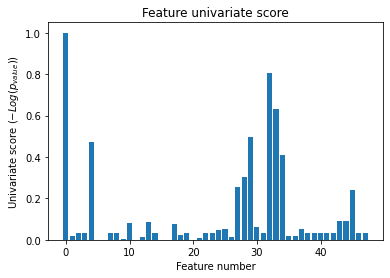

In [143]:
import matplotlib.pyplot as plt

# Create the X_indices array using the shape of the scores array
X_indices = np.arange(scores.shape[0])

# Create a new figure
plt.figure(1)
plt.clf()

# Plot the scores as a bar chart
plt.bar(X_indices, scores)

# Add a title, x-label, and y-label
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")

# Show the plot
plt.show()


In [60]:
print(scores)

[1.00000000e+00 1.87317254e-02 3.32367554e-02 3.32367554e-02
 4.70079209e-01 3.75807459e-04 3.75807459e-04 3.32367554e-02
 3.32367554e-02 2.63484435e-03 7.93885076e-02 5.00860935e-04
 1.47365948e-02 8.54835137e-02 3.23730342e-02 5.00860935e-04
 1.32152448e-03 7.59477521e-02 2.18349202e-02 3.32367554e-02
 8.21346843e-04 8.03111007e-03 3.32367554e-02 3.32367554e-02
 4.72746015e-02 4.99826575e-02 1.52941236e-02 2.55026537e-01
 3.05626517e-01 4.98486145e-01 6.03446941e-02 3.32367554e-02
 8.07464921e-01 6.30652313e-01 4.09403142e-01 1.87950295e-02
 1.87950295e-02 5.30955151e-02 3.32367554e-02 3.32367554e-02
 3.32367554e-02 3.32367554e-02 3.32367554e-02 9.07080976e-02
 9.07080976e-02]


In [121]:
selector2 = SelectKBest(f_classif, k=5)
selector2.fit(X_train_scaled, y_train)

# Replace zeros in the pvalues_ array with a small non-zero value
selector2.pvalues_[selector2.pvalues_ == 0] = 1e-10

scores2 = -np.log10(selector2.pvalues_)
scores2 /= scores2.max()

# Get the boolean array indicating which features were selected
selected_top5 = selector2.get_support()

# Convert the X_train_scaled array into a DataFrame
X_train_scaled_df = pd.DataFrame(X_train)

# Get the column names of the X_train_scaled_df DataFrame
feature_names2 = X_train_scaled_df.columns.tolist()

# Print the names of the selected features
print("Top 5 Selected features predicting likelihood of claim approval:")
for i, feature in enumerate(selected_top5):
    if feature:
        print(f"{i}: {feature_names2[i]}")

Top 5 Selected features predicting likelihood of claim approval:
2: Closed Count
8: Attorney/Representative_Y
19: Claim Injury Type_1. CANCELLED
46: y_NO FURTHER ACTION
47: y_Unresloved


In [144]:
# Get the boolean array indicating which features were selected
selected = selector.get_support()

# Convert the X_train_scaled array into a DataFrame
X_train_scaled_df = pd.DataFrame(X_train)

# Get the column names of the X_train_scaled_df DataFrame
feature_names = X_train_scaled_df.columns.tolist()

# Print the names of the selected features
print("Selected features:")
for i, feature in enumerate(selected):
    if feature:
        print(f"{i}: {feature_names[i]}")


Selected features:
2: Closed Count
3: Hearing Count
7: Attorney/Representative_N
8: Attorney/Representative_Y
19: Claim Injury Type_1. CANCELLED
22: Claim Injury Type_4. TEMPORARY
23: Claim Injury Type_5. PPD SCH LOSS
31: District Name_NYC
38: Highest Process_2. ADMINISTRATIVE DETERMINATION
40: Highest Process_4A. HEARING - JUDGE
41: Highest Process_4B. HEARING - APPEAL
42: Highest Process_4C. HEARING - SETTLEMENT
46: y_NO FURTHER ACTION
47: y_Unresloved


In [62]:
selected

array([ True, False,  True,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True, False, False])

#### Selecting the top 14 features for modelling:

In [145]:
# Select the top k features from the training and test datasets using the selector object
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

##### Starting with the Decision Tree Model:

In [146]:
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier object
clf_dt1 = DecisionTreeClassifier()

# Train the classifier on the training data
clf_dt1.fit(X_train_selected, y_train)

# Predict the labels for the test data
y_pred_df = clf_dt1.predict(X_test_selected)

In [149]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Compute the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred_df)

# Compute the precision of the predictions
precision = precision_score(y_test, y_pred_df)

# Compute the recall of the predictions
recall = recall_score(y_test, y_pred_df)


# Print the results
print(f"Decision Tree1 Accuracy: {accuracy: .4f}")
print(f"Decision Tree1 Precision: {precision: .4f}")
print(f"Decision Tree1 Recall: {recall: .4f}")

Decision Tree1 Accuracy:  1.0000
Decision Tree1 Precision:  1.0000
Decision Tree1 Recall:  1.0000


Precision and Recall tell the model needs improvement, regardless of the shown accuracy. We will try the Stochastic Gradient now:


In [72]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Create an SGDClassifier object
clf_sgd = SGDClassifier(random_state=42)

# Create a StratifiedKFold object with 5 folds
skf = StratifiedKFold(n_splits=5)

# Use cross-validation to evaluate the classifier's performance
scores = cross_val_score(clf_sgd, X_train_selected, y_train, cv=skf)

# Print the mean and standard deviation of the scores
print(f"Mean score:, {scores.mean(): .4f}")
print(f"Standard deviation:, {scores.std(): .4f}")


Mean score:,  0.9732
Standard deviation:,  0.0000


In [124]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Create an SGDClassifier object
clf_sgd = SGDClassifier(random_state = 42, loss = "log")

# Create a StratifiedKFold object with 5 folds
skf = StratifiedKFold(n_splits=5)

# Use cross-validation to make predictions on the training data
y_pred = cross_val_predict(clf_sgd, X_train_selected, y_train, cv=skf)

# Compute the precision of the predictions
precision = precision_score(y_train, y_pred)

# Compute the recall of the predictions
recall = recall_score(y_train, y_pred)

# Compute the F1 score of the predictions
accuracy_sgd = accuracy_score(y_train, y_pred)

# Compute the F1 score of the predictions
f1 = f1_score(y_train, y_pred)

# Print the results
print(f"Precision: {precision: .4f}")
print(f"Accuracy: {accuracy_sgd: .4f}")
print(f"Recall: {recall: .4f}")
print(f"F1 score: {f1: .4f}")

Precision:  0.8833
Accuracy:  0.9732
Recall:  0.0296
F1 score:  0.0574


##### This low F1 score suggests that the SGD classifier is performing poorly in terms of both precision and recall.

Visualizing the ROC Curve:

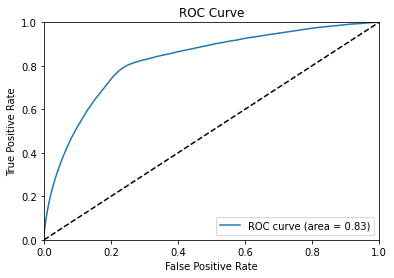

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba_sgd = cross_val_predict(clf_sgd, X_train_selected, y_train, cv=skf, method="predict_proba")

# Extract the predicted probabilities of the positive class
y_pred_proba_sgd = y_pred_proba_sgd[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_sgd)

# Compute the AUC score
auc = roc_auc_score(y_train, y_pred_proba_sgd)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Confusion Matrix

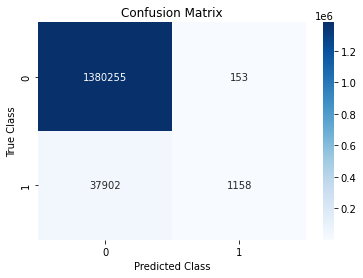

In [81]:
import seaborn as sns

conf_matrix = confusion_matrix(y_train, y_pred)

# Visualize the confusion matrix using Seaborn's heatmap() function
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Using a Random Forest Classifier:

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a RandomForestClassifier object
clf_rf = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
clf_rf.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred_rf = clf_rf.predict(X_test_selected)

# Compute the accuracy of the predictions
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Compute the precision of the predictions
precision_rf = precision_score(y_test, y_pred_rf)

# Compute the recall of the predictions
recall_rf = recall_score(y_test, y_pred_rf)

# Compute the F1 score of the predictions
f1_rf = f1_score(y_test, y_pred_rf)


# Print the results
print("Accuracy: {:.4f}".format(accuracy_rf))
print("Precision: {:.4f}".format(precision_rf))
print("Recall: {:.4f}".format(recall_rf))
print("F1 score: {:.4f}".format(f1_rf))

Accuracy: 0.9721
Precision: 0.4658
Recall: 0.1011
F1 score: 0.1661


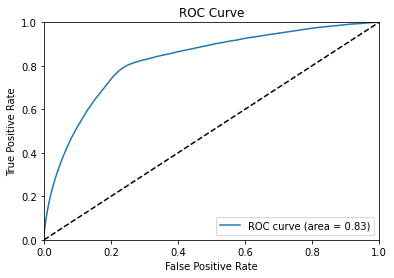

In [92]:
y_pred_rf2 = cross_val_predict(clf_sgd, X_train_selected, y_train, cv=skf, method="predict_proba")

# Extract the predicted probabilities of the positive class
y_pred_rf2 = y_pred_rf2[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_train, y_pred_rf2)

# Compute the AUC score
auc = roc_auc_score(y_train, y_pred_rf2)

# Plot the ROC curve
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()